# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# **Basic** Gradient Descent for Multiple Linear Regression

In [16]:
# imports 
import pandas as pd # import pandas for easy data manipulation using data frames
import numpy as np  # import numpy for numeric calculations on matrices
import time         # for timers

# import h2o to check calculations
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

#### Assign global constants

In [17]:
# data-related constants
IN_FILE_PATH = '../data/loan_clean.csv'
Y            = 'STD_IMP_REP_loan_amnt'
DROPS        = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
                'GRP_purpose', 'GRP_verification_status', '_WARN_']

# model-related constants
LEARN_RATE   = 0.005 # how much each gradient descent step impacts parameters
CONV         = 1e-10 # desired precision in parameters 
MAX_ITERS    = 10000 # maximum number of gradient descent steps to allow

### Import clean data and convert to numpy matrices

In [18]:
# import data using Pandas
raw = pd.read_csv(IN_FILE_PATH)

In [19]:
# select target column
y = raw[Y].as_matrix()
print(y)

[-1.01918221 -1.33470843 -1.34732948 ..., -0.03158515  1.83948532
  0.49534363]


In [20]:
# create input matrix
# add an additional column of 1's for intercept 
# by overlaying inputs onto matrix of 1's
numeric = raw.drop(DROPS + [Y], axis=1).as_matrix()
N, p = numeric.shape
X = np.ones(shape=(N, p + 1))
X[:,1:] = numeric 
print(X)

[[ 1.          0.         -1.1992995  ...,  1.18587165 -0.51649558
  -1.35927825]
 [ 1.          1.         -1.04507688 ..., -1.78827033  1.97187876
  -1.79651802]
 [ 1.          0.         -1.50126739 ...,  1.77829832 -0.51649558
  -1.27183029]
 ..., 
 [ 1.          0.         -0.83944672 ...,  0.66549687 -0.51649558
  -0.04755892]
 [ 1.          0.         -0.27396377 ...,  0.285223    1.97187876
  -0.39735074]
 [ 1.          0.         -0.19484757 ..., -0.00298457  1.97187876
   0.3022329 ]]


### Basic Gradient Descent Routines

#### Define squared loss function
* For linear regression, we minimize the squared distance between the regression plane and points in the conditional distribution of **y** given **X**.
* It is convenient to use a scaled mean squared error (MSE) formula:

In [21]:
def squared_loss(n, x, y, betas):
    
    """ Squared loss function for multiple linear regression.
    
    :param n: Number of rows in x.
    :param x: Matrix of numeric inputs.
    :param y: Vector of known target values.
    :param beta: Vector or current model parameters.
    :return: Scalar MSE value.    
    
    """
    
    yhat = x.dot(betas)
        
    return ((1 / (2 * n)) * (y - yhat)**2).sum()

#### Define gradient of loss function
* The derivative of the loss function w.r.t the model parameters is used to update model parameters at each gradient descent step.
* The gradient of our MSE loss function is trivial:

In [22]:
def grad(n, y, yhat):
    
    """ Analytical gradient of scaled MSE loss function.
    
    :param n: Number of rows in X.
    :param y: Vector of known target values.
    :param yhat: Vector of predicted target values.
    :return: Vector of gradient values.
    
    """
    
    return ((1 / n)*(yhat - y))

#### Define function for executing gradient descent minimization
For each gradient descent step:
* Predictions are made using the current model parameters.
* The gradient is calculated for each model pararmeter.
* The gradient is used in combination with the learning rate to update each parameter.

In [23]:
def grad_descent(X, y, learn_rate, max_iters, sgd_mini_batch_n=0):
    
    """ Routine for executing simple gradient descent with stochastic gradient descent option.
    
    :param X: Matrix of numeric data.
    :param y: Vector of known target values.
    :param learn_rate: Learning rate.
    :param max_iters: Maximum number of gradient descent steps to perform.
    :param sgd_mini_batch_n: Minibatch size for sgd optimization.
                             If > 0 minibatch stochastic gradient descent is performed.
    
    """

    tic = time.time()               # start timer
    n_betas = X.shape[1]            # number of model parameters including bias    
    betas = np.zeros(shape=n_betas) # parameters start with value of 0
    n = y.shape[0]                  # number of rows in X
    
    # Pandas dataframe for iteration history
    iteration_frame = pd.DataFrame(columns=['Iteration', 'Loss'])

    print('Iteration history:')
    
    # loop for gradient descent steps
    for i in range(max_iters):
        
        # stochastic gradient descent
        if sgd_mini_batch_n > 0:
            
            samp_idx = np.random.randint(n, size=sgd_mini_batch_n)
            X_samp = X[samp_idx, :]
            y_samp = y[samp_idx]
            n_samp = X_samp.shape[0]
            yhat_samp = X_samp.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):

                # select column
                # calculate column-wise gradient
                # update corresponding parameter based on negative gradient
                # calculate loss

                xj_samp = X_samp[:, j]
                xj_grad_samp = grad(n_samp, y_samp, yhat_samp) * xj_samp
                betas[j] = betas[j] - learn_rate * xj_grad_samp.sum()
                iter_loss = squared_loss(n_samp, X_samp, y_samp, betas)
        
        # standard gradient descent
        else:
            
            yhat = X.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):
                xj = X[:, j]
                xj_grad = grad(n, y, yhat) * xj
                betas[j] = betas[j] - learn_rate * xj_grad.sum()
                iter_loss = squared_loss(n, X, y, betas)
        
        # update loss history
        iteration_frame = iteration_frame.append({'Iteration': i,
                                                  'Loss':  iter_loss}, 
                                                  ignore_index=True)        
        # progress indicator 
        if i % 1000 == 0:
            print('iter=%d loss=%.6f' % (i, iter_loss))
        
        # convergence check
        if i > 0:
            if np.abs(iteration_frame.iat[i-1, 1] - iteration_frame.iat[i, 1]) < CONV:
                break

    # output 
    %matplotlib inline
    iteration_frame.plot.line(title='Iteration Plot', x='Iteration', y='Loss')
    print()           
    print('Model parameters at iteration ' + str(i) + ':')
    print(betas)
    print()
    print('Model trained in %.2f s.' % (time.time()-tic))


#### Execute gradient descent

Iteration history:
iter=0 loss=0.497186
iter=1000 loss=0.315239
iter=2000 loss=0.315038
iter=3000 loss=0.315029
iter=4000 loss=0.315028
iter=5000 loss=0.315027

Model parameters at iteration 5451:
[-0.00931092  0.04850417  0.4184085  -0.0423755   0.08968925  0.03013954
  0.08019815  0.05024616  0.0155436   0.31241567  0.04137116]

Model trained in 134.14 s.


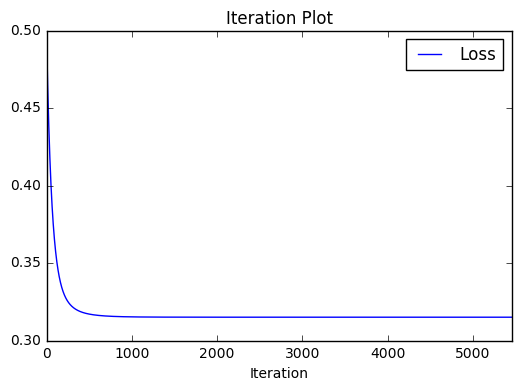

In [24]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS)

#### Execute stochastic gradient descent

Iteration history:
iter=0 loss=0.504182
iter=1000 loss=0.342006
iter=2000 loss=0.311546
iter=3000 loss=0.325628
iter=4000 loss=0.330037
iter=5000 loss=0.359612
iter=6000 loss=0.286463
iter=7000 loss=0.301586
iter=8000 loss=0.303301
iter=9000 loss=0.318988

Model parameters at iteration 9999:
[-0.00913744  0.048172    0.42078809 -0.0436005   0.09299575  0.03144586
  0.08038705  0.05091495  0.01603481  0.31296612  0.04337472]

Model trained in 15.34 s.


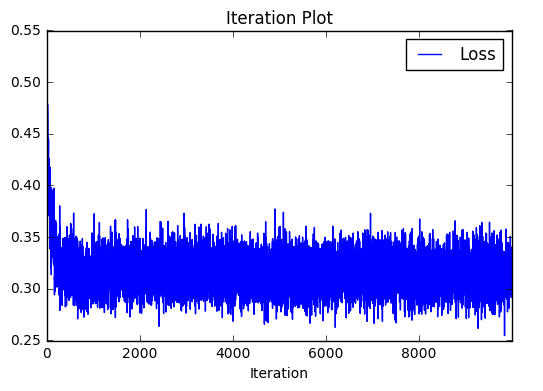

In [25]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, sgd_mini_batch_n=1000)

### Use h2o to check model parameters

In [26]:
# start h2o
h2o.init()

DROPS = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
         'GRP_purpose', 'GRP_verification_status', '_WARN_']

# numeric columns 
train = h2o.import_file(IN_FILE_PATH)
train = train.drop(DROPS)
X = train.col_names

# initialize non-penalized GLM model
loan_glm = H2OGeneralizedLinearEstimator(family='gaussian',      # uses squared error
                                         solver='IRLSM',         # necessary for non-penalized GLM
                                         standardize=False,      # data is already standardized
                                         compute_p_values=True,  # necessary for non-penalized GLM 
                                         lambda_=0)              # necessary for non-penalized GLM

# train 
loan_glm.train(train.col_names, Y, training_frame=train)

# print trained model info
print() 
print('Model parameters:')
for name, val in loan_glm.coef().items():
    print(name, val)
print()

# shutdown h2o
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm43py4jh
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm43py4jh/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpm43py4jh/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ------------------------------
H2O cluster uptime:         04 secs
H2O cluster version:        3.11.0.3873
H2O cluster version age:    13 days
H2O cluster name:           H2O_from_python_phall_0gd0qd
H2O cluster total nodes:    1
H2O cluster free memory:    3.556 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.5.2 final
--------------------------  ------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%

Model parameters:
STD_IMP_REP_longest_credit_lengt 0.05023821933458787
STD_IMP_REP_annual_inc 0.4184344038333887
STD_IMP_REP_delinq_2yrs -0.04237426505134887
Intercept -0.009531837795372198
STD_IMP_REP_term_length 0.31239210762608416
STD_IMP_REP_emp_length 0.030142903020478177
bad_loan 0.0494917361604361
STD_IMP_REP_total_acc 0.041392767737906726
STD_IMP_REP_int_rate 0.08011731349769495
STD_IMP_REP_revol_util 0.015542387042639275
STD_IMP_REP_dti 0.08966404330351398

H2O session _sid_9ecc closed.
